<a href="https://colab.research.google.com/github/massimocipressi/MLPNS_MCipressi/blob/main/generativeAI/superresolve_aenc_faces_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [3]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#cd /content/gdrive/Shareddrives/


In [4]:
cd /content/gdrive/MyDrive/MPLNS2023


/content/gdrive/MyDrive/MPLNS2023


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [ ]:
#!unzip faces95.zip

In [ ]:
!ls 

faces95        spm-20210427T111354Z-001.zip  wine.data
HiggsBoson     transformer_h1_history	     wine.data.1
KaggleTitanic  transformer_h1_model.h5	     wine.names
model.png      transformer_h4_history	     wine.names.1
spm	       transformer_h4_model.h5


In [ ]:
flist = glob.glob("faces95/*/*jpg")

In [ ]:
N = len(flist)
N

1441


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

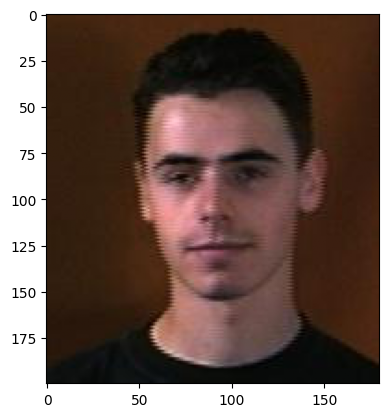

In [ ]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

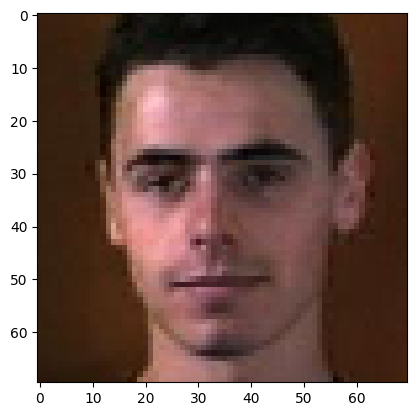

In [ ]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>

In [ ]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

<ipython-input-10-8d7a10a391be>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1441 [00:00<?, ?it/s]

In [ ]:
np.save("faces_saved.npy", imgs)

# 1B you can read the images below if you have saved them earlier

In [5]:
imgs = np.load("faces_saved.npy")
imgs.shape

(1441, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [6]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [7]:
# lower the resolution
# imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
imgs_orig = imgs_orig[:, :-6, :-6, :]
imgs_orig.shape
imgs_lr = imgs_orig[:,::2,::2]
imgs_lr.shape

(1441, 32, 32, 1)

In [8]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1024, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [ ]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, 
                                             test_size = .20, random_state=1)
  

In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1152, 35, 35), (289, 35, 35), (1152, 70, 70, 1), (289, 70, 70, 1))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [ ]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=1225))
model.add(Dense(128, activation='relu', name="bottleneck"))
model.add(Dense(256, activation='relu'))
model.add(Dense(1225, activation='relu'))
model.add(Dense(1225*4, activation='sigmoid'))
model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 bottleneck (Dense)          (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1225)              314825    
                                                                 
 dense_3 (Dense)             (None, 4900)              6007400   
                                                                 
Total params: 6,702,001
Trainable params: 6,702,001
Non-trainable params: 0
_________________________________________________________________
None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [ ]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [ ]:
model.fit?

In [ ]:
# you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100000, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])
model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
72/72 [==============================] - 7s 11ms/step - loss: 0.0420 - mae: 0.1614 - acc: 0.0026 - val_loss: 0.0315 - val_mae: 0.1362 - val_acc: 0.0000e+00
Epoch 2/100000
72/72 [==============================] - 1s 8ms/step - loss: 0.0268 - mae: 0.1257 - acc: 0.0043 - val_loss: 0.0215 - val_mae: 0.1105 - val_acc: 0.0000e+00
Epoch 3/100000
72/72 [==============================] - 1s 8ms/step - loss: 0.0202 - mae: 0.1074 - acc: 0.0026 - val_loss: 0.0185 - val_mae: 0.1019 - val_acc: 0.0000e+00
Epoch 4/100000
72/72 [==============================] - 1s 7ms/step - loss: 0.0181 - mae: 0.1004 - acc: 8.6806e-04 - val_loss: 0.0171 - val_mae: 0.0959 - val_acc: 0.0035
Epoch 5/100000
72/72 [==============================] - 1s 7ms/step - loss: 0.0159 - mae: 0.0930 - acc: 0.0035 - val_loss: 0.0167 - val_mae: 0.0969 - val_acc: 0.0035
Epoch 6/100000
72/72 [==============================] - 1s 7ms/step - loss: 0.0144 - mae: 0.0883 - acc: 0.0017 - val_loss: 0.0142 - val_mae: 0.0869 - val

In [ ]:
model.save("data/imgreconstruct_10000.h5")

In [ ]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("data/imgreconstruct_10000.h5")

## predict

In [ ]:
outim = model.predict(X_te)
outim

10/10 [==============================] - 0s 2ms/step


array([[0.3069986 , 0.30566758, 0.31578475, ..., 0.18251584, 0.15704675,
        0.16530225],
       [0.2977724 , 0.26891878, 0.27076262, ..., 0.21974792, 0.21013574,
        0.14576136],
       [0.22288196, 0.22980519, 0.23664567, ..., 0.13508384, 0.12699425,
        0.13096741],
       ...,
       [0.23473486, 0.24046192, 0.25661385, ..., 0.19358943, 0.18354905,
        0.18174653],
       [0.19381832, 0.19032872, 0.1924857 , ..., 0.15001245, 0.15860829,
        0.16711429],
       [0.19868775, 0.20539704, 0.2099213 , ..., 0.3370231 , 0.2836888 ,
        0.26624   ]], dtype=float32)

In [ ]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


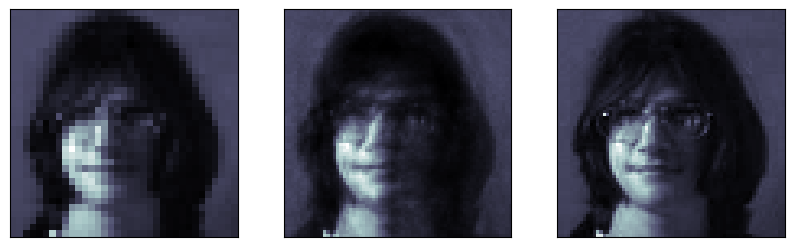

2 :	input		      prediction		  target


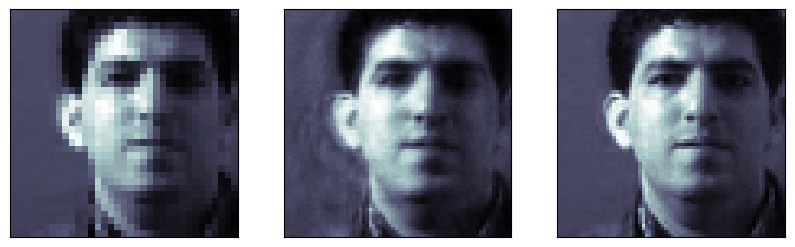

3 :	input		      prediction		  target


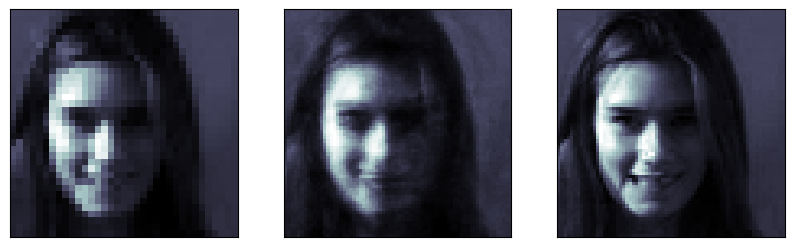

4 :	input		      prediction		  target


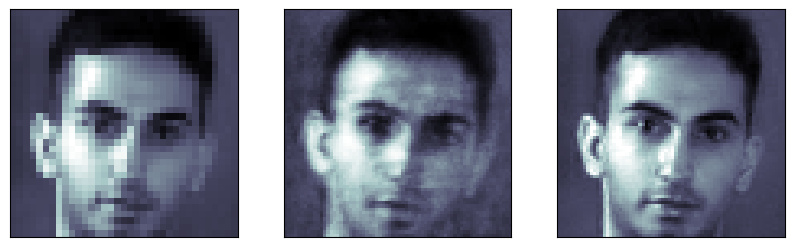

5 :	input		      prediction		  target


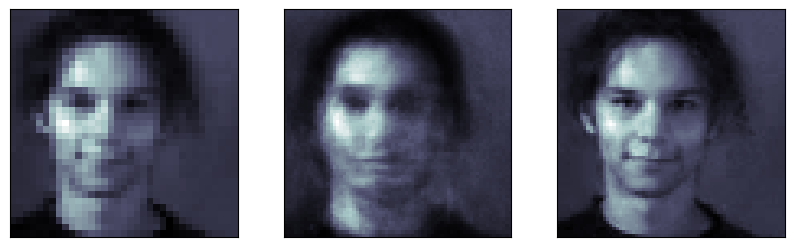

6 :	input		      prediction		  target


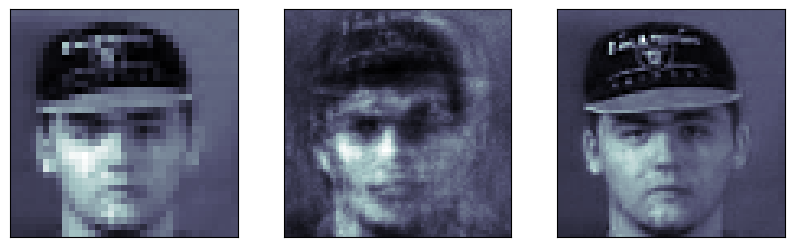

7 :	input		      prediction		  target


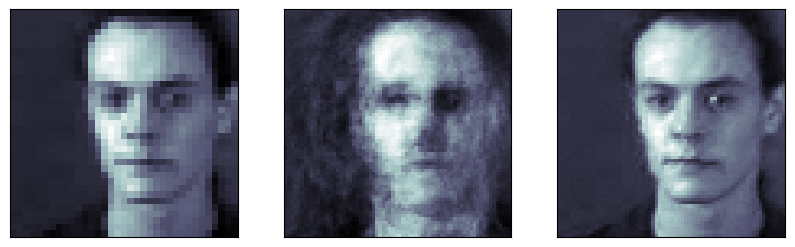

8 :	input		      prediction		  target


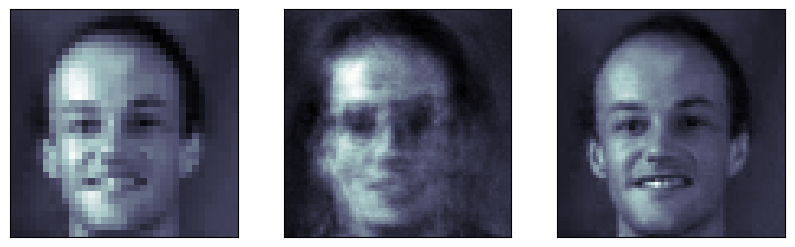

9 :	input		      prediction		  target


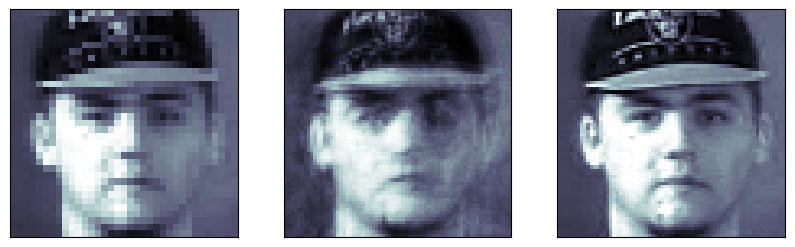

10 :	input		      prediction		  target


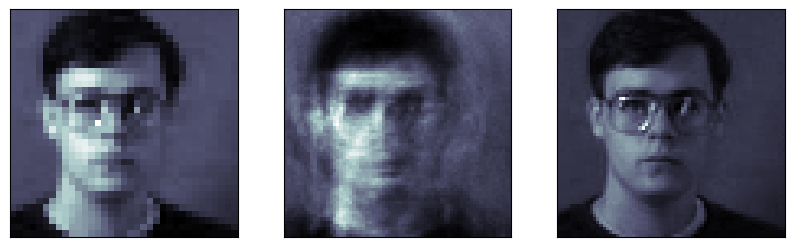

In [ ]:
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

In [ ]:
#i casi peggiori sono quelli di visi fuori centro o con il cappello
#questi rappresentanto casi isolati, il modello non ha imparato abbastanza su di essi
#per quanto riguarda questi, è più un problema di bias nel dataset che del modello

## show the latent representation of the data: the bottleneck layer output

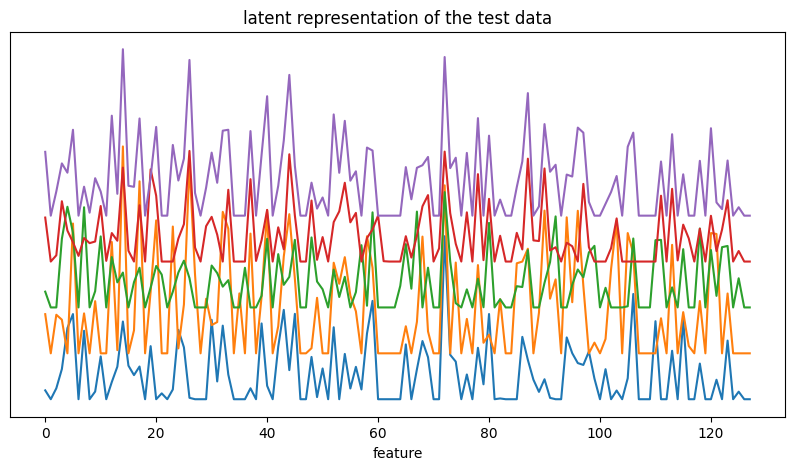

In [ ]:
from keras import backend as K
# input placeholder
inp = model.input                   
# extract the bottle neck outputs
outputs = model.layers[1].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(X_te[:5])
  
for i in range(5):
  pl.plot(layer_outs[0][i] + i)

pl.xlabel("feature")
pl.yticks([],"")
pl.title("latent representation of the test data");

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()


Saving mia foto.jpg to mia foto (1).jpg


In [ ]:
file_contents = uploaded[list(uploaded.keys())[0]]


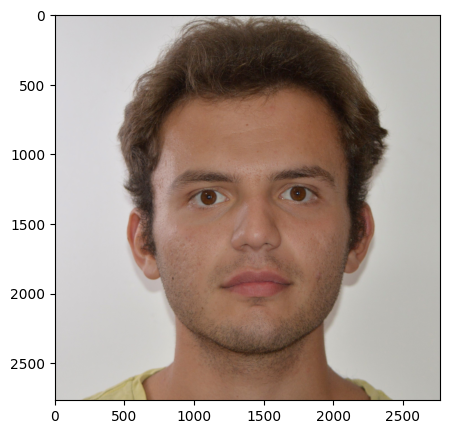

In [ ]:
imme = Image.open(BytesIO(file_contents))
plt.imshow(imme)

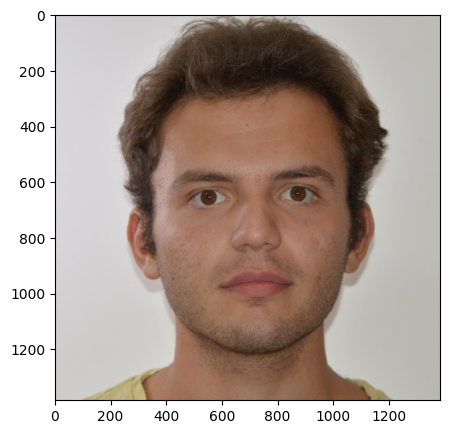

In [ ]:

np_im = numpy.array(imme)[::2,::2,:3].astype(float) / 255
pl.figure()
pl.imshow(np_im)
np_im.shape, np.prod(np_im.shape[1:]);


low resolution version
subsampling by 15

In [ ]:
np_im.shape

(1384, 1384, 3)

In [ ]:
np_im_me = np_im[::39,::39,1]
np_im_me = np.delete(np_im_me,35,axis=1)
np_im_me = np.delete(np_im_me,35,axis=0)
np_im_me.shape

(35, 35)

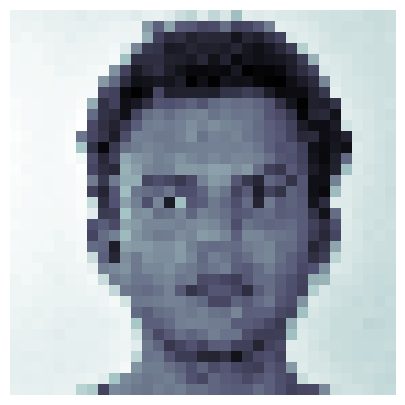

In [ ]:

pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

1/1 [==============================] - 0s 20ms/step


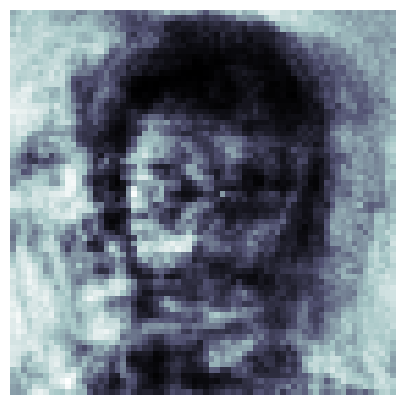

In [ ]:
pl.imshow(model.predict(np.array([np_im_me.flatten()])).reshape(70,70), 
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??

In [ ]:
#lo stile dell'immagine è diverso
#in particolare lo sfondo è bianco e non grigio